<a href="https://colab.research.google.com/github/NinelK/SA_DS_tutorial/blob/main/LFADS_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import datetime
import h5py
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
from jax.config import config
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import scipy.signal
import scipy.stats
import os
import sys
import time
from importlib import reload

In [2]:
# %%capture
! pip install "dandi>=0.13.0"
# ! dandi download DANDI:000140/0.220113.0408
! pip install git+https://github.com/neurallatents/nlb_tools.git
# ! git clone https://github.com/google-research/computation-thru-dynamics.git # needs Runtime restart?

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neurallatents/nlb_tools.git to /tmp/pip-req-build-qxbpdmw1
  Running command git clone -q https://github.com/neurallatents/nlb_tools.git /tmp/pip-req-build-qxbpdmw1


In [6]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
# sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics','lfads_tutorial'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

import matplotlib.pyplot as plt
import pandas as pd
from nlb_tools.nwb_interface import NWBDataset

In [7]:
onp_rng = onp.random.RandomState(seed=0) # For CPU-based numpy randomness

In [49]:
# Make directories
lfads_dir = '/content/lfads/'       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

# Load data

# for simplicity, we are using NLB tools 
dataset = NWBDataset("/content/000140/sub-Jenkins", "*train", 
                     split_heldout=False)

bin = 10 # [ms]
dataset.resample(bin)

# to view the dataset, uncomment the next line
# dataset.data

In [50]:
input_key = 'spikes'
output_key = 'hand_vel'

# Extract neural data and lagged hand velocity
trial_length = 500//bin
trial_data = dataset.make_trial_data(align_field='move_onset_time', 
                                     align_range=(-13*bin, -13*bin+bin*trial_length))
lagged_trial_data = dataset.make_trial_data(align_field='move_onset_time', 
                                      align_range=(0, 0+bin*trial_length))

print(trial_data['trial_id'].to_numpy().reshape((-1,trial_length)))
inputs = trial_data[input_key].to_numpy() 
outputs = lagged_trial_data[output_key].to_numpy()

input_size = inputs.shape[-1]
output_size = outputs.shape[-1]

print(input_size,output_size)

inputs = inputs.reshape((-1,trial_length,input_size)) # [trials x time x inputs]
outputs = outputs.reshape((-1,trial_length,output_size)) # [trials x time x outputs]

data_bxtxn = inputs
data_bxtxn.shape

[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [97 97 97 ... 97 97 97]
 [98 98 98 ... 98 98 98]
 [99 99 99 ... 99 99 99]]
142 2


(100, 50, 142)

In [51]:
data_dt = 10.0        # define our dt in a physiological range [ms]

train_fraction = 0.9      # Train with 90% of the synthetic data

nexamples, ntimesteps, data_dim = data_bxtxn.shape

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

In [52]:
import sklearn
ncomponents = 100
full_pca = sklearn.decomposition.PCA(ncomponents)
full_pca.fit(onp.reshape(data_bxtxn, [-1, data_dim]))

PCA(n_components=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


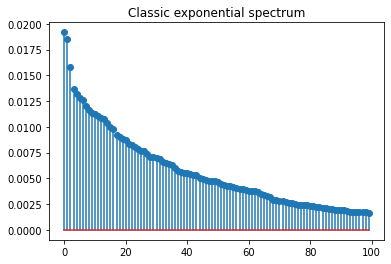

In [12]:
plt.stem(full_pca.explained_variance_)
plt.title('Classic exponential spectrum');

In [53]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 45      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 64         # encoder dim
con_dim = 64         # controller dim
ii_dim = 1            # inferred input dim, we know there is 1 dim in integrator RNN
gen_dim = 64         # generator dim, should be large enough to generate integrator RNN dynamics
factors_dim = 4      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
# Again, these hyper parameters are set "in the ballpark" but otherwise
# pretty randomly.
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 20000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9999      # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.95            # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 500.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = 0.01 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.0

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-1}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

In [54]:
# Initialize parameters for LFADS
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps)

In [55]:
key = random.PRNGKey(onp.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
                   train_data, eval_data)

Batches 1-100 in 24.22 sec, Step size: 0.00990
    Training losses 1179 = NLL 1177 + KL IC 193,2 + KL II 12,0 + L2 0.04
        Eval losses 1137 = NLL 1135 + KL IC 194,2 + KL II 12,0 + L2 0.04
Batches 101-200 in 3.19 sec, Step size: 0.00980
    Training losses 1136 = NLL 1134 + KL IC 107,1 + KL II 123,1 + L2 0.04
        Eval losses 1093 = NLL 1091 + KL IC 106,1 + KL II 116,1 + L2 0.04
Batches 201-300 in 3.18 sec, Step size: 0.00970
    Training losses 1100 = NLL 1098 + KL IC 67,1 + KL II 132,1 + L2 0.04
        Eval losses 1090 = NLL 1088 + KL IC 64,1 + KL II 126,1 + L2 0.04
Batches 301-400 in 3.18 sec, Step size: 0.00961
    Training losses 1106 = NLL 1105 + KL IC 49,0 + KL II 128,1 + L2 0.05
        Eval losses 1085 = NLL 1083 + KL IC 48,0 + KL II 119,1 + L2 0.05
Batches 401-500 in 3.18 sec, Step size: 0.00951
    Training losses 1090 = NLL 1089 + KL IC 30,0 + KL II 119,1 + L2 0.05
        Eval losses 1086 = NLL 1085 + KL IC 25,0 + KL II 112,1 + L2 0.05
Batches 501-600 in 3.18 sec, 

In [57]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_lfads_140' + fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)


Saving parameters:  /content/lfads/output/trained_params_lfads_1402022-07-28_14:39:28.npz


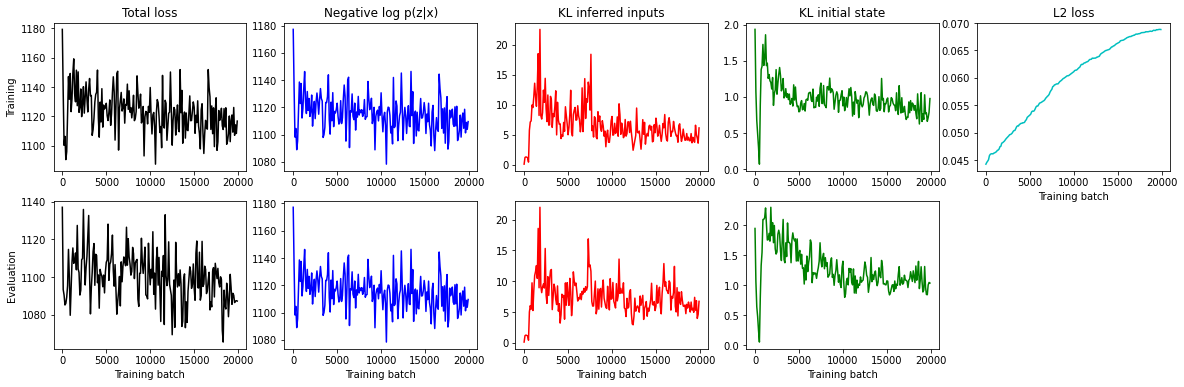

In [58]:
# Plot the training details
x = onp.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

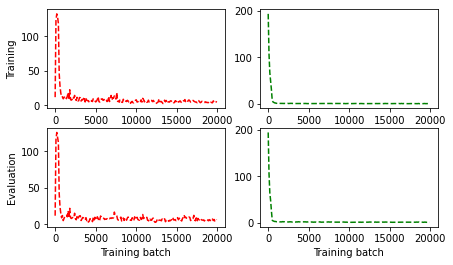

In [59]:
# See the effect of the KL warmup, which is shown 
# by the KL penalities without the warmup scaling. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Training batch');

## Visualization

In [75]:
# Plot a bunch of examples of eval trials run through LFADS.
reload(plotting)
#reload(lfads)

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac


bidx = 0

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(np.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example)

    # The inferred input and true input are rescaled and shifted via 
    # linear regression to match, as there is an identifiability issue. there.
    plotting.plot_lfads(psa_example, psa_dict,
                        data_dict, eval_data_offset+bidx, plot_rescale_fun)


NameError: ignored

dict_keys(['c_t', 'factor_t', 'gen_t', 'ic_logvar', 'ic_mean', 'ii_logvar_t', 'ii_mean_t', 'ii_t', 'lograte_t', 'xenc_t'])

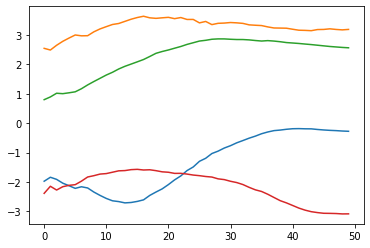

In [76]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [88]:
print(trained_params.keys())
trained_params['gen'].keys()

dict_keys(['con', 'con_out', 'factors', 'gen', 'gen_ic', 'ic_enc', 'ic_prior', 'ii_prior', 'logrates'])


dict_keys(['bC', 'bRU', 'h0', 'wCHX', 'wRUHX'])